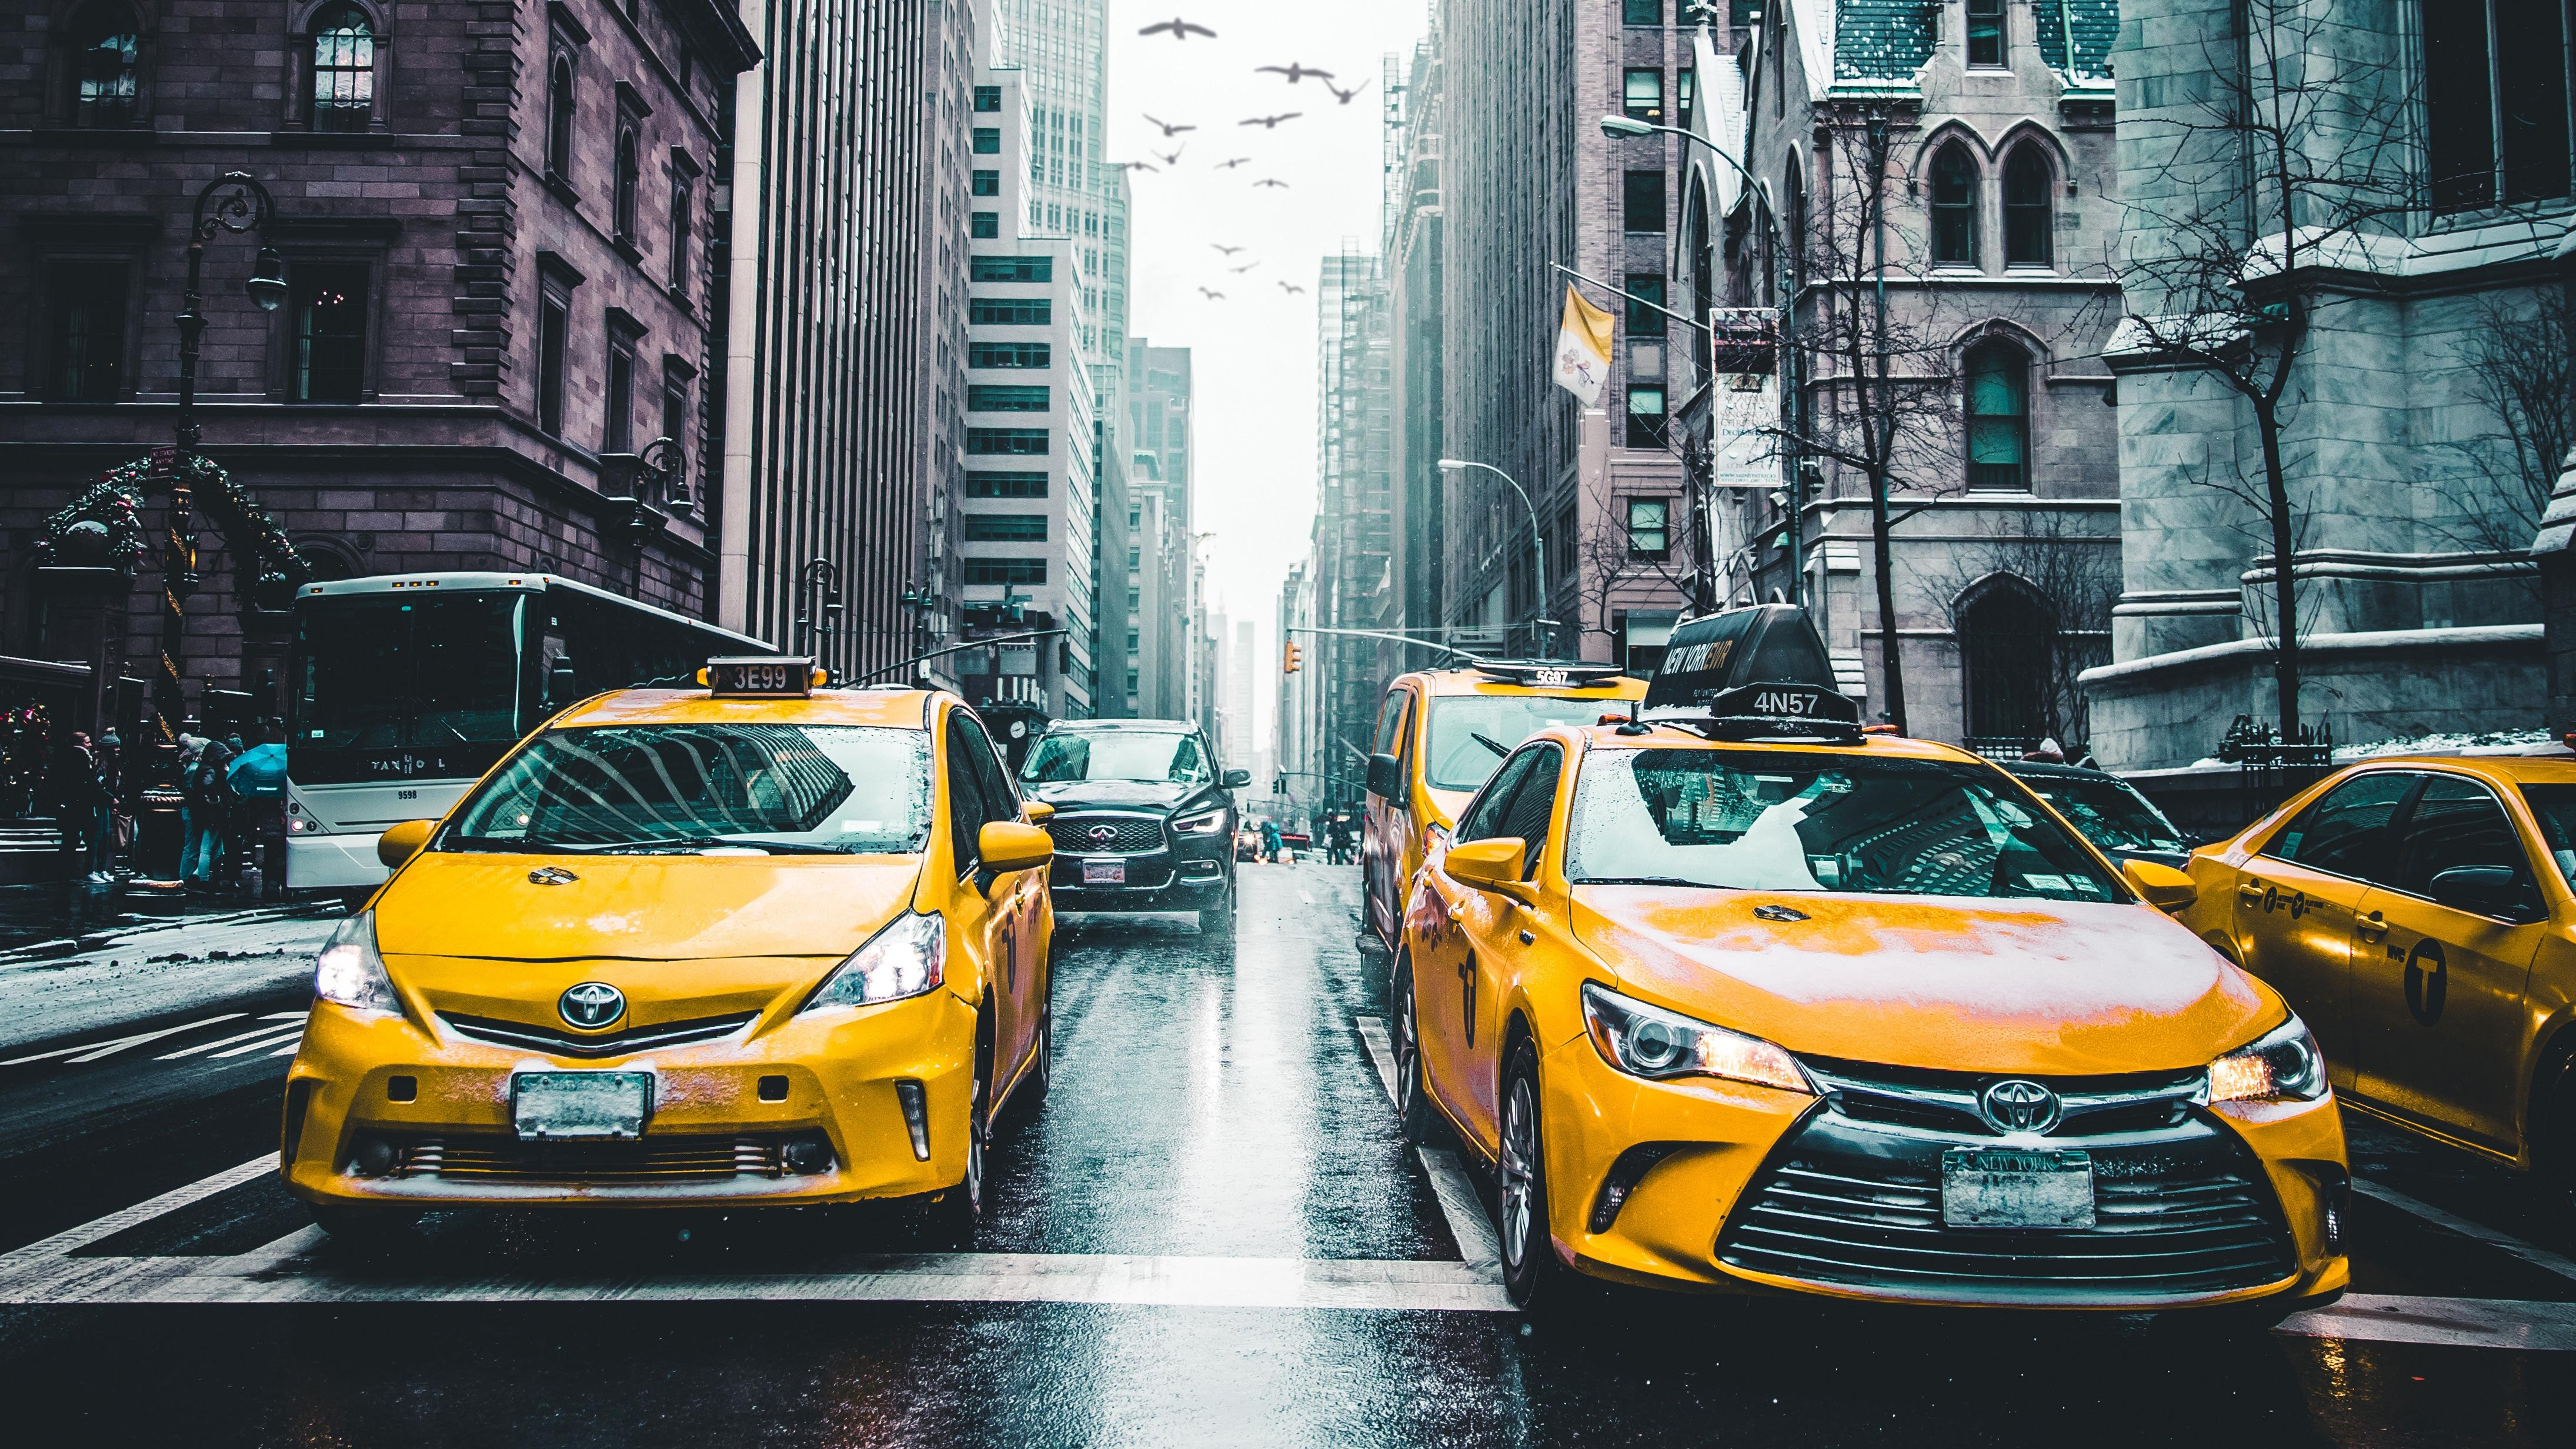

# Problem Statement: 
The business problem tackled here is trying to improve customer service for YourCabs.com, a cab company in Bangalore.
The problem of interest is booking cancellations by the company due to unavailability of a car. The challenge is that cancellations can occur very close to the trip start time, thereby causing passengers inconvenience.

# Solution
The goal of the competition is to create a predictive model for classifying new bookings as to whether they will eventually get cancelled due to car unavailability or not

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import warnings
import datetime
from geopy import distance
warnings.filterwarnings('ignore')

# Importing Data

In [2]:
df = pd.read_csv('C:/Users/91968/Learnbay/Stats and ML/Capstone project - YourCabs/YourCabs.csv')
df.head()

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation
0,132512,22177,28,NaN,2,83.0,448.0,NaN,NaN,01-01-2013 02:00,0,0,01-01-2013 01:39,12.924150,77.672290,12.927320,77.635750,0
1,132513,21413,12,NaN,2,1010.0,540.0,NaN,NaN,01-01-2013 09:00,0,0,01-01-2013 02:25,12.966910,77.749350,12.927680,77.626640,0
2,132514,22178,12,NaN,2,1301.0,1034.0,NaN,NaN,01-01-2013 03:30,0,0,01-01-2013 03:08,12.937222,77.626915,13.047926,77.597766,0
3,132515,13034,12,NaN,2,768.0,398.0,NaN,NaN,01-01-2013 05:45,0,0,01-01-2013 04:39,12.989990,77.553320,12.971430,77.639140,0
4,132517,22180,12,NaN,2,1365.0,849.0,NaN,NaN,01-01-2013 09:00,0,0,01-01-2013 07:53,12.845653,77.677925,12.954340,77.600720,0


# Analysing the data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43431 entries, 0 to 43430
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   43431 non-null  int64  
 1   user_id              43431 non-null  int64  
 2   vehicle_model_id     43431 non-null  int64  
 3   package_id           7550 non-null   float64
 4   travel_type_id       43431 non-null  int64  
 5   from_area_id         43343 non-null  float64
 6   to_area_id           34293 non-null  float64
 7   from_city_id         16345 non-null  float64
 8   to_city_id           1588 non-null   float64
 9   from_date            43431 non-null  object 
 10  online_booking       43431 non-null  int64  
 11  mobile_site_booking  43431 non-null  int64  
 12  booking_created      43431 non-null  object 
 13  from_lat             43338 non-null  float64
 14  from_long            43338 non-null  float64
 15  to_lat               34293 non-null 

In [4]:
df['vehicle_model_id'].value_counts(normalize=True)

12    0.733554
85    0.055421
89    0.055053
65    0.044024
28    0.039189
24    0.034399
87    0.013009
90    0.007184
23    0.006838
86    0.002832
10    0.002395
64    0.001957
54    0.001681
17    0.000921
91    0.000576
30    0.000322
36    0.000207
13    0.000161
72    0.000046
1     0.000046
43    0.000046
14    0.000023
69    0.000023
76    0.000023
75    0.000023
70    0.000023
39    0.000023
Name: vehicle_model_id, dtype: float64

In [5]:
#Column id has unique values 
#Column user_id contains PII (Personal Information Identifier) which would be of no use while training the model 
#Column vehicle_model_id has 73% of the values as '12' so keeping it will introduce a bias

# So we will drop all these columns

df.drop(columns = ['id', 'user_id', 'vehicle_model_id'], inplace=True)

df.head()

,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation
0,NaN,2,83.0,448.0,NaN,NaN,01-01-2013 02:00,0,0,01-01-2013 01:39,12.924150,77.672290,12.927320,77.635750,0
1,NaN,2,1010.0,540.0,NaN,NaN,01-01-2013 09:00,0,0,01-01-2013 02:25,12.966910,77.749350,12.927680,77.626640,0
2,NaN,2,1301.0,1034.0,NaN,NaN,01-01-2013 03:30,0,0,01-01-2013 03:08,12.937222,77.626915,13.047926,77.597766,0
3,NaN,2,768.0,398.0,NaN,NaN,01-01-2013 05:45,0,0,01-01-2013 04:39,12.989990,77.553320,12.971430,77.639140,0
4,NaN,2,1365.0,849.0,NaN,NaN,01-01-2013 09:00,0,0,01-01-2013 07:53,12.845653,77.677925,12.954340,77.600720,0


In [6]:
'''Split the data into 3 parts: travel_type_id = 1, travel_type_id = 2 and travel_type_id = 3 as each travel type id has some columns required and some are not required
And create 3 ML models for each travel type id.'''

df1 = df[df['travel_type_id']==1]
df2 = df[df['travel_type_id']==2]
df3 = df[df['travel_type_id']==3]


# Working with the 1st dataset - df1

In [7]:
df1.head()

,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation
6,NaN,1,571.0,NaN,15.0,108.0,01-01-2013 09:45,0,0,01-01-2013 09:21,12.951850,77.696420,NaN,NaN,0
17,NaN,1,1383.0,NaN,NaN,32.0,01-12-2013 08:00,1,0,01-01-2013 12:17,12.930451,77.685822,NaN,NaN,0
24,NaN,1,515.0,NaN,15.0,32.0,01-05-2013 08:30,0,0,01-01-2013 14:40,12.978960,77.673450,NaN,NaN,0
158,NaN,1,136.0,NaN,1.0,152.0,01-04-2013 09:30,1,0,01-03-2013 12:19,12.907960,77.624180,NaN,NaN,0
216,NaN,1,1118.0,NaN,NaN,32.0,01-06-2013 07:30,1,0,01-04-2013 09:32,12.930220,77.560390,NaN,NaN,0


In [8]:
df1.isnull().sum()

package_id             1589
travel_type_id            0
from_area_id             88
to_area_id             1588
from_city_id            196
to_city_id                1
from_date                 0
online_booking            0
mobile_site_booking       0
booking_created           0
from_lat                 93
from_long                93
to_lat                 1588
to_long                1588
Car_Cancellation          0
dtype: int64

In [9]:
# In df1 containing travel_type_id = 1, as it is a long distance or intercity travel, the columns package_id, to_area_id, to_lat and to_long will have null values only so need to drop these columns
# We can also delete the column travel_type_id as it is the same for this dataset
df1.drop(columns = ['package_id', 'to_area_id', 'to_lat', 'to_long', 'travel_type_id'], inplace=True)
df1.head()

,from_area_id,from_city_id,to_city_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,Car_Cancellation
6,571.0,15.0,108.0,01-01-2013 09:45,0,0,01-01-2013 09:21,12.951850,77.696420,0
17,1383.0,NaN,32.0,01-12-2013 08:00,1,0,01-01-2013 12:17,12.930451,77.685822,0
24,515.0,15.0,32.0,01-05-2013 08:30,0,0,01-01-2013 14:40,12.978960,77.673450,0
158,136.0,1.0,152.0,01-04-2013 09:30,1,0,01-03-2013 12:19,12.907960,77.624180,0
216,1118.0,NaN,32.0,01-06-2013 07:30,1,0,01-04-2013 09:32,12.930220,77.560390,0


<Axes: >

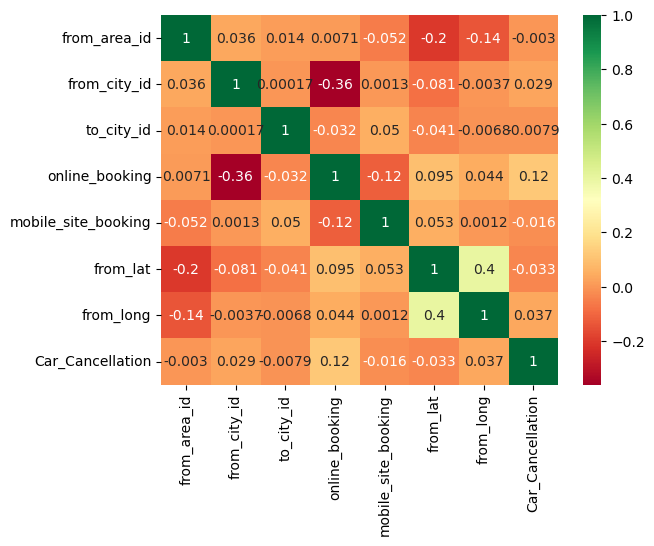

In [10]:
sns.heatmap(df1.corr(), annot = True, cmap = 'RdYlGn')

In [11]:
# From the above correlation matrix, we can observe that from_area_id is in high correlation with from_lat and from_long so need to drop the latter 2 columns due to multi colinearity

df1.drop(columns = ['from_lat', 'from_long'], inplace = True)
df1.head()

,from_area_id,from_city_id,to_city_id,from_date,online_booking,mobile_site_booking,booking_created,Car_Cancellation
6,571.0,15.0,108.0,01-01-2013 09:45,0,0,01-01-2013 09:21,0
17,1383.0,NaN,32.0,01-12-2013 08:00,1,0,01-01-2013 12:17,0
24,515.0,15.0,32.0,01-05-2013 08:30,0,0,01-01-2013 14:40,0
158,136.0,1.0,152.0,01-04-2013 09:30,1,0,01-03-2013 12:19,0
216,1118.0,NaN,32.0,01-06-2013 07:30,1,0,01-04-2013 09:32,0


In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1589 entries, 6 to 43407
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   from_area_id         1501 non-null   float64
 1   from_city_id         1393 non-null   float64
 2   to_city_id           1588 non-null   float64
 3   from_date            1589 non-null   object 
 4   online_booking       1589 non-null   int64  
 5   mobile_site_booking  1589 non-null   int64  
 6   booking_created      1589 non-null   object 
 7   Car_Cancellation     1589 non-null   int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 111.7+ KB


### Missing value treatment

In [13]:
print((df1['from_area_id'].isnull().sum())*100/df1.shape[0]) # % of NaN values in from_area_id column

# As the missing value % is almost 5% we will treat it by replacing it with the mean

df1['from_area_id'] = df1['from_area_id'].fillna(df1['from_area_id'].mean())

print((df1['from_city_id'].isnull().sum())*100/df1.shape[0]) # % of NaN values in from_city_id column

# Since this column contains more than 10% of missing values, we will drop this column

df1.drop(columns = 'from_city_id', inplace = True)

print((df1['to_city_id'].isnull().sum())*100/df1.shape[0]) # % of NaN values in from_area_id column

# As the missing value % is less than 5% we will treat it by replacing it with the mean

df1['to_city_id'] = df1['to_city_id'].fillna(df1['to_city_id'].mean())

5.5380742605412205
12.334801762114537
0.06293266205160478


In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1589 entries, 6 to 43407
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   from_area_id         1589 non-null   float64
 1   to_city_id           1589 non-null   float64
 2   from_date            1589 non-null   object 
 3   online_booking       1589 non-null   int64  
 4   mobile_site_booking  1589 non-null   int64  
 5   booking_created      1589 non-null   object 
 6   Car_Cancellation     1589 non-null   int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 99.3+ KB


In [15]:
df1.head()

,from_area_id,to_city_id,from_date,online_booking,mobile_site_booking,booking_created,Car_Cancellation
6,571.0,108.0,01-01-2013 09:45,0,0,01-01-2013 09:21,0
17,1383.0,32.0,01-12-2013 08:00,1,0,01-01-2013 12:17,0
24,515.0,32.0,01-05-2013 08:30,0,0,01-01-2013 14:40,0
158,136.0,152.0,01-04-2013 09:30,1,0,01-03-2013 12:19,0
216,1118.0,32.0,01-06-2013 07:30,1,0,01-04-2013 09:32,0


### Extracting date and time from timestamp

In [16]:
df1['from_time_tm'] = pd.to_datetime(df1['from_date']).dt.strftime('%H:%M') # extracting time component from from_date column
df1['booking_created_tm'] = pd.to_datetime(df1['booking_created']).dt.strftime('%H:%M') # extracting time component from booking_created column

# Classifying the time into different segments for both the columns

cond = [(pd.to_datetime(df1['from_time_tm']).dt.hour.between(5, 8)),
        (pd.to_datetime(df1['from_time_tm']).dt.hour.between(9, 12)),
        (pd.to_datetime(df1['from_time_tm']).dt.hour.between(13, 16)),
        (pd.to_datetime(df1['from_time_tm']).dt.hour.between(17, 20)),
        ((pd.to_datetime(df1['from_time_tm']).dt.hour.between(21, 24)) | (pd.to_datetime(df1['from_time_tm']).dt.hour==0)),
        (pd.to_datetime(df1['from_time_tm']).dt.hour.between(1, 4))]
values = ['Early Morning','Morning','Afternoon','Evening','Night','Late Night']
df1['from_date_session'] = np.select(cond,values)

cond = [(pd.to_datetime(df1['booking_created_tm']).dt.hour.between(5, 8)),
        (pd.to_datetime(df1['booking_created_tm']).dt.hour.between(9, 12)),
        (pd.to_datetime(df1['booking_created_tm']).dt.hour.between(13, 16)),
        (pd.to_datetime(df1['booking_created_tm']).dt.hour.between(17, 20)),
        ((pd.to_datetime(df1['booking_created_tm']).dt.hour.between(21, 24)) | (pd.to_datetime(df1['booking_created_tm']).dt.hour==0)),
        (pd.to_datetime(df1['booking_created_tm']).dt.hour.between(1, 4))]
values = ['Early Morning','Morning','Afternoon','Evening','Night','Late Night']
df1['booking_created_session'] = np.select(cond,values)

In [17]:
# creating a new column which calculates the time difference between booking time and scheduled travel time

df1['time_diff'] = (pd.to_datetime(df1['from_date']) - pd.to_datetime(df1['booking_created'])).astype('timedelta64[m]')

In [18]:
df1

,from_area_id,to_city_id,from_date,online_booking,mobile_site_booking,booking_created,Car_Cancellation,from_time_tm,booking_created_tm,from_date_session,booking_created_session,time_diff
6,571.0,108.0,01-01-2013 09:45,0,0,01-01-2013 09:21,0,09:45,09:21,Morning,Morning,24.0
17,1383.0,32.0,01-12-2013 08:00,1,0,01-01-2013 12:17,0,08:00,12:17,Early Morning,Morning,15583.0
24,515.0,32.0,01-05-2013 08:30,0,0,01-01-2013 14:40,0,08:30,14:40,Early Morning,Afternoon,5390.0
158,136.0,152.0,01-04-2013 09:30,1,0,01-03-2013 12:19,0,09:30,12:19,Morning,Morning,1271.0
216,1118.0,32.0,01-06-2013 07:30,1,0,01-04-2013 09:32,0,07:30,09:32,Early Morning,Morning,2758.0
...,...,...,...,...,...,...,...,...,...,...,...,...
43342,393.0,191.0,11/23/2013 22:00,1,0,11/23/2013 17:54,0,22:00,17:54,Night,Evening,246.0
43385,119.0,146.0,11/29/2013 14:00,1,0,11/23/2013 23:24,0,14:00,23:24,Afternoon,Night,8076.0
43386,1281.0,32.0,11/24/2013 7:30,1,0,11/23/2013 23:44,0,07:30,23:44,Early Morning,Night,466.0
43393,393.0,116.0,11/24/2013 10:30,0,0,11/24/2013 7:14,0,10:30,07:14,Morning,Early Morning,196.0


In [19]:
# dropping some columns from the data

df1.drop(columns = ['from_date', 'booking_created', 'from_time_tm', 'booking_created_tm'], inplace = True)

In [20]:
df1

,from_area_id,to_city_id,online_booking,mobile_site_booking,Car_Cancellation,from_date_session,booking_created_session,time_diff
6,571.0,108.0,0,0,0,Morning,Morning,24.0
17,1383.0,32.0,1,0,0,Early Morning,Morning,15583.0
24,515.0,32.0,0,0,0,Early Morning,Afternoon,5390.0
158,136.0,152.0,1,0,0,Morning,Morning,1271.0
216,1118.0,32.0,1,0,0,Early Morning,Morning,2758.0
...,...,...,...,...,...,...,...,...
43342,393.0,191.0,1,0,0,Night,Evening,246.0
43385,119.0,146.0,1,0,0,Afternoon,Night,8076.0
43386,1281.0,32.0,1,0,0,Early Morning,Night,466.0
43393,393.0,116.0,0,0,0,Morning,Early Morning,196.0


### Data Visualisation

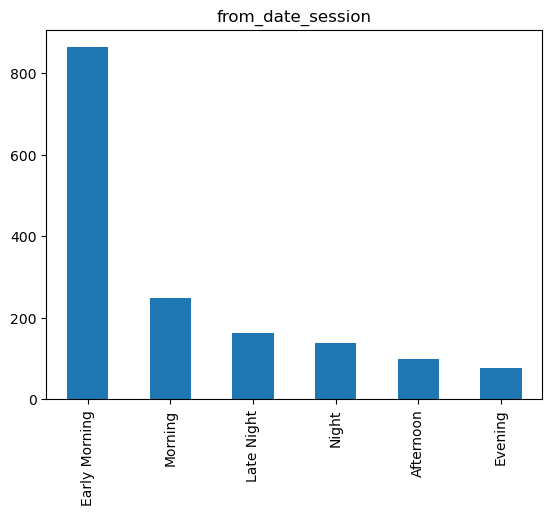

In [21]:
df1['from_date_session'].value_counts().plot.bar()
plt.title('from_date_session')
plt.show()

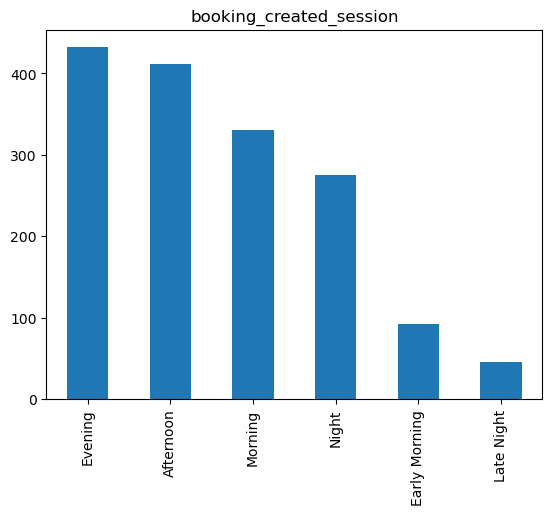

In [22]:
df1['booking_created_session'].value_counts().plot.bar()
plt.title('booking_created_session')
plt.show()

### Extracting features and target from df1

In [23]:
df1

,from_area_id,to_city_id,online_booking,mobile_site_booking,Car_Cancellation,from_date_session,booking_created_session,time_diff
6,571.0,108.0,0,0,0,Morning,Morning,24.0
17,1383.0,32.0,1,0,0,Early Morning,Morning,15583.0
24,515.0,32.0,0,0,0,Early Morning,Afternoon,5390.0
158,136.0,152.0,1,0,0,Morning,Morning,1271.0
216,1118.0,32.0,1,0,0,Early Morning,Morning,2758.0
...,...,...,...,...,...,...,...,...
43342,393.0,191.0,1,0,0,Night,Evening,246.0
43385,119.0,146.0,1,0,0,Afternoon,Night,8076.0
43386,1281.0,32.0,1,0,0,Early Morning,Night,466.0
43393,393.0,116.0,0,0,0,Morning,Early Morning,196.0


In [24]:
x1 = df1.drop(columns = 'Car_Cancellation')
x1.head()

,from_area_id,to_city_id,online_booking,mobile_site_booking,from_date_session,booking_created_session,time_diff
6,571.0,108.0,0,0,Morning,Morning,24.0
17,1383.0,32.0,1,0,Early Morning,Morning,15583.0
24,515.0,32.0,0,0,Early Morning,Afternoon,5390.0
158,136.0,152.0,1,0,Morning,Morning,1271.0
216,1118.0,32.0,1,0,Early Morning,Morning,2758.0


In [25]:
y1 = df1['Car_Cancellation']
y1.head()

6      0
17     0
24     0
158    0
216    0
Name: Car_Cancellation, dtype: int64

### Splitting the data

In [26]:
y1.value_counts()

0    1568
1      21
Name: Car_Cancellation, dtype: int64

In [27]:
# here the target class is biased so we need to pass stratify argument while splitting the data

In [28]:
xtrain1, xtest1, ytrain1, ytest1 = train_test_split(x1,y1,train_size=0.85,random_state=30, stratify=y1)

In [29]:
xtrain1

,from_area_id,to_city_id,online_booking,mobile_site_booking,from_date_session,booking_created_session,time_diff
19818,1166.0,65.0,1,0,Afternoon,Afternoon,13076.0
18554,585.0,55.0,0,0,Early Morning,Morning,1241.0
19385,585.0,32.0,1,0,Early Morning,Afternoon,907.0
43250,393.0,64.0,0,0,Morning,Evening,3650.0
19694,105.0,192.0,1,0,Early Morning,Early Morning,2803.0
...,...,...,...,...,...,...,...
20676,1102.0,17.0,0,0,Morning,Early Morning,62.0
37840,1164.0,147.0,1,0,Early Morning,Morning,1168.0
31662,689.0,191.0,1,0,Early Morning,Afternoon,940.0
1017,466.0,108.0,0,0,Early Morning,Late Night,141.0


In [30]:
xtest1

,from_area_id,to_city_id,online_booking,mobile_site_booking,from_date_session,booking_created_session,time_diff
10833,455.0,146.0,1,0,Evening,Evening,5735.0
19114,1153.0,110.0,1,0,Early Morning,Night,1952.0
29007,293.0,146.0,0,0,Night,Afternoon,468.0
34062,393.0,32.0,1,0,Morning,Afternoon,4278.0
20450,1013.0,146.0,0,0,Afternoon,Morning,99.0
...,...,...,...,...,...,...,...
37662,396.0,32.0,1,0,Morning,Early Morning,299.0
8352,1333.0,32.0,0,0,Early Morning,Night,444.0
1314,87.0,32.0,1,0,Early Morning,Evening,2322.0
20092,571.0,32.0,0,0,Early Morning,Morning,1222.0


### Data Scaling

In [31]:
from sklearn.preprocessing import MinMaxScaler
m2s = MinMaxScaler()

In [32]:
xtrain1['time_diff'] = m2s.fit_transform(xtrain1[['time_diff']])
xtrain1.head()

,from_area_id,to_city_id,online_booking,mobile_site_booking,from_date_session,booking_created_session,time_diff
19818,1166.0,65.0,1,0,Afternoon,Afternoon,0.199333
18554,585.0,55.0,0,0,Early Morning,Morning,0.019797
19385,585.0,32.0,1,0,Early Morning,Afternoon,0.014730
43250,393.0,64.0,0,0,Morning,Evening,0.056341
19694,105.0,192.0,1,0,Early Morning,Early Morning,0.043492


In [33]:
xtest1['time_diff'] = m2s.transform(xtest1[['time_diff']])
xtest1.head()

,from_area_id,to_city_id,online_booking,mobile_site_booking,from_date_session,booking_created_session,time_diff
10833,455.0,146.0,1,0,Evening,Evening,0.087970
19114,1153.0,110.0,1,0,Early Morning,Night,0.030583
29007,293.0,146.0,0,0,Night,Afternoon,0.008070
34062,393.0,32.0,1,0,Morning,Afternoon,0.065868
20450,1013.0,146.0,0,0,Afternoon,Morning,0.002473


### Data Encoding

In [34]:
# One-hot encoding for the columns from_date_session and booking_created_session

from_date_dummy = pd.get_dummies(xtrain1['from_date_session'], drop_first=True)

In [35]:
from_date_dummy

,Early Morning,Evening,Late Night,Morning,Night
19818,0,0,0,0,0
18554,1,0,0,0,0
19385,1,0,0,0,0
43250,0,0,0,1,0
19694,1,0,0,0,0
...,...,...,...,...,...
20676,0,0,0,1,0
37840,1,0,0,0,0
31662,1,0,0,0,0
1017,1,0,0,0,0


In [36]:
xtrain1['Early_Morning'] = from_date_dummy['Early Morning']
xtrain1['Evening'] = from_date_dummy['Evening']
xtrain1['Late_Night'] = from_date_dummy['Late Night']
xtrain1['Morning'] = from_date_dummy['Morning']
xtrain1['Night'] = from_date_dummy['Night']
del xtrain1['from_date_session']

In [37]:
booking_created_dummy = pd.get_dummies(xtrain1['booking_created_session'], drop_first=True)

In [38]:
booking_created_dummy

,Early Morning,Evening,Late Night,Morning,Night
19818,0,0,0,0,0
18554,0,0,0,1,0
19385,0,0,0,0,0
43250,0,1,0,0,0
19694,1,0,0,0,0
...,...,...,...,...,...
20676,1,0,0,0,0
37840,0,0,0,1,0
31662,0,0,0,0,0
1017,0,0,1,0,0


In [39]:
xtrain1['Early_Morning_booking'] = booking_created_dummy['Early Morning']
xtrain1['Evening_booking'] = booking_created_dummy['Evening']
xtrain1['Late_Night_booking'] = booking_created_dummy['Late Night']
xtrain1['Morning_booking'] = booking_created_dummy['Morning']
xtrain1['Night_booking'] = booking_created_dummy['Night']
del xtrain1['booking_created_session']

In [40]:
xtrain1

,from_area_id,to_city_id,online_booking,mobile_site_booking,time_diff,Early_Morning,Evening,Late_Night,Morning,Night,Early_Morning_booking,Evening_booking,Late_Night_booking,Morning_booking,Night_booking
19818,1166.0,65.0,1,0,0.199333,0,0,0,0,0,0,0,0,0,0
18554,585.0,55.0,0,0,0.019797,1,0,0,0,0,0,0,0,1,0
19385,585.0,32.0,1,0,0.014730,1,0,0,0,0,0,0,0,0,0
43250,393.0,64.0,0,0,0.056341,0,0,0,1,0,0,1,0,0,0
19694,105.0,192.0,1,0,0.043492,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20676,1102.0,17.0,0,0,0.001911,0,0,0,1,0,1,0,0,0,0
37840,1164.0,147.0,1,0,0.018689,1,0,0,0,0,0,0,0,1,0
31662,689.0,191.0,1,0,0.015231,1,0,0,0,0,0,0,0,0,0
1017,466.0,108.0,0,0,0.003110,1,0,0,0,0,0,0,1,0,0


In [41]:
from_date_dummy_test = pd.get_dummies(xtest1['from_date_session'], drop_first=True)

In [42]:
from_date_dummy_test

,Early Morning,Evening,Late Night,Morning,Night
10833,0,1,0,0,0
19114,1,0,0,0,0
29007,0,0,0,0,1
34062,0,0,0,1,0
20450,0,0,0,0,0
...,...,...,...,...,...
37662,0,0,0,1,0
8352,1,0,0,0,0
1314,1,0,0,0,0
20092,1,0,0,0,0


In [43]:
xtest1['Early_Morning'] = from_date_dummy_test['Early Morning']
xtest1['Evening'] = from_date_dummy_test['Evening']
xtest1['Late_Night'] = from_date_dummy_test['Late Night']
xtest1['Morning'] = from_date_dummy_test['Morning']
xtest1['Night'] = from_date_dummy_test['Night']
del xtest1['from_date_session']

In [44]:
booking_created_dummy_test = pd.get_dummies(xtest1['booking_created_session'], drop_first=True)

In [45]:
booking_created_dummy_test

,Early Morning,Evening,Late Night,Morning,Night
10833,0,1,0,0,0
19114,0,0,0,0,1
29007,0,0,0,0,0
34062,0,0,0,0,0
20450,0,0,0,1,0
...,...,...,...,...,...
37662,1,0,0,0,0
8352,0,0,0,0,1
1314,0,1,0,0,0
20092,0,0,0,1,0


In [46]:
xtest1['Early_Morning_booking'] = booking_created_dummy_test['Early Morning']
xtest1['Evening_booking'] = booking_created_dummy_test['Evening']
xtest1['Late_Night_booking'] = booking_created_dummy_test['Late Night']
xtest1['Morning_booking'] = booking_created_dummy_test['Morning']
xtest1['Night_booking'] = booking_created_dummy_test['Night']
del xtest1['booking_created_session']

In [47]:
xtest1

,from_area_id,to_city_id,online_booking,mobile_site_booking,time_diff,Early_Morning,Evening,Late_Night,Morning,Night,Early_Morning_booking,Evening_booking,Late_Night_booking,Morning_booking,Night_booking
10833,455.0,146.0,1,0,0.087970,0,1,0,0,0,0,1,0,0,0
19114,1153.0,110.0,1,0,0.030583,1,0,0,0,0,0,0,0,0,1
29007,293.0,146.0,0,0,0.008070,0,0,0,0,1,0,0,0,0,0
34062,393.0,32.0,1,0,0.065868,0,0,0,1,0,0,0,0,0,0
20450,1013.0,146.0,0,0,0.002473,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37662,396.0,32.0,1,0,0.005507,0,0,0,1,0,1,0,0,0,0
8352,1333.0,32.0,0,0,0.007706,1,0,0,0,0,0,0,0,0,1
1314,87.0,32.0,1,0,0.036195,1,0,0,0,0,0,1,0,0,0
20092,571.0,32.0,0,0,0.019508,1,0,0,0,0,0,0,0,1,0


### Building the model for df1

In [48]:
# Logistic Regression

log_reg = LogisticRegression(random_state=0)
log_reg.fit(xtrain1, ytrain1)

LogisticRegression(random_state=0)

In [49]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion='gini',random_state=4)

In [50]:
from sklearn.model_selection import GridSearchCV
param_dist = {'max_depth': [3, 5, 6, 7], 'min_samples_split': [50, 100, 150, 200, 250]}
gscv_dtc = GridSearchCV(dtc, cv=10, param_grid=param_dist, n_jobs=-1)
gscv_dtc.fit(xtrain1, ytrain1)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=4), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 7],
                         'min_samples_split': [50, 100, 150, 200, 250]})

In [51]:
gscv_dtc.best_params_

{'max_depth': 3, 'min_samples_split': 150}

In [52]:
dtc = DecisionTreeClassifier(criterion='gini', random_state = 4, max_depth = 3, min_samples_split = 150)
dtc.fit(xtrain1, ytrain1)

DecisionTreeClassifier(max_depth=3, min_samples_split=150, random_state=4)

### Prediction for test dataset

In [53]:
ypred_lr =log_reg.predict(xtest1)
ypred_lr

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [54]:
ypred_dtc = dtc.predict(xtest1)
ypred_dtc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

### Model evaluation

In [55]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(ytest1, ypred_lr)
conf_matrix

array([[236,   0],
       [  3,   0]], dtype=int64)

<Axes: >

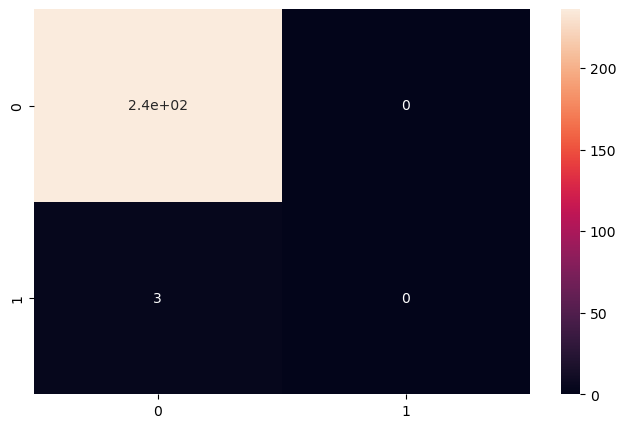

In [56]:
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(conf_matrix, annot = True, ax=ax)

In [61]:
from sklearn.metrics import classification_report
print("Report for Logistic Regression")
print("______________________________")
print("\n")
print(classification_report(ytest1, ypred_lr))

Report for Logistic Regression
______________________________


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       236
           1       0.00      0.00      0.00         3

    accuracy                           0.99       239
   macro avg       0.49      0.50      0.50       239
weighted avg       0.98      0.99      0.98       239



In [64]:
conf_matrix = confusion_matrix(ytest1, ypred_dtc)
conf_matrix

array([[236,   0],
       [  3,   0]], dtype=int64)

In [65]:
print("Report for Decision Tree Model")
print("______________________________")
print("\n")
print(classification_report(ytest1, ypred_dtc))

Report for Decision Tree Model
______________________________


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       236
           1       0.00      0.00      0.00         3

    accuracy                           0.99       239
   macro avg       0.49      0.50      0.50       239
weighted avg       0.98      0.99      0.98       239



### ROC and AUC

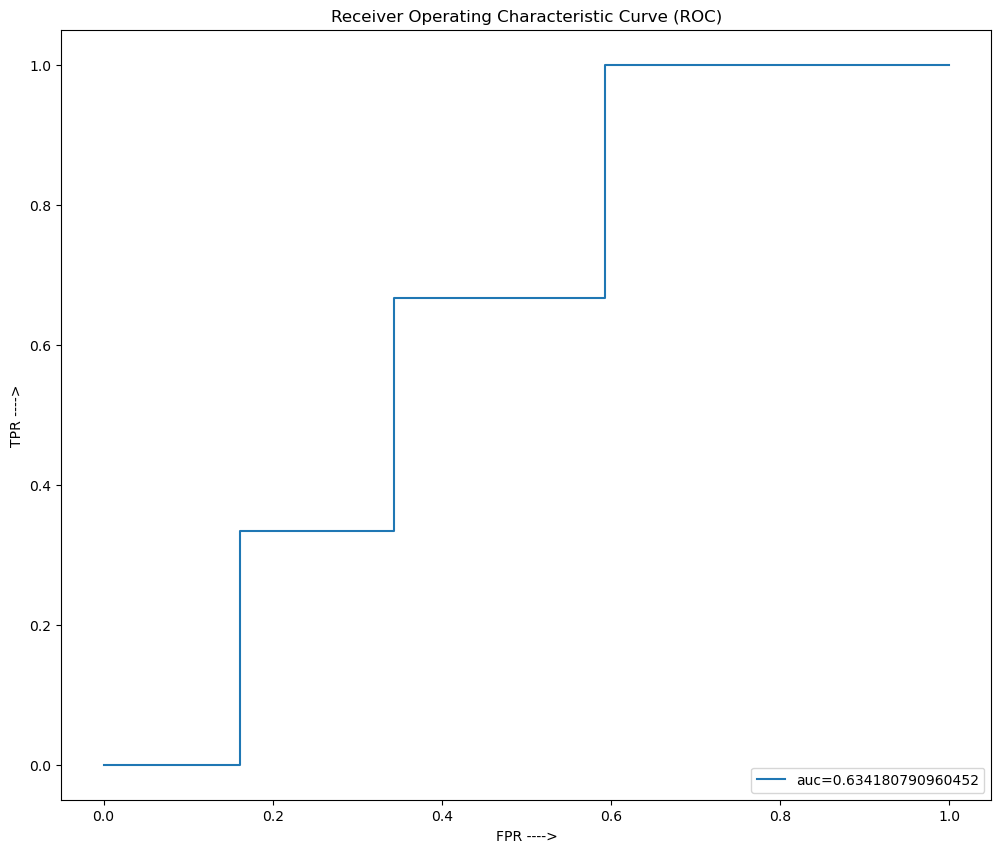

In [70]:
y_pred_proba = log_reg.predict_proba(xtest1)[::,1]
fpr, tpr, _ = metrics.roc_curve(ytest1,  y_pred_proba)
auc = metrics.roc_auc_score(ytest1, y_pred_proba)
plt.figure(figsize=(12,10))
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.title("Receiver Operating Characteristic Curve (ROC)")
plt.xlabel("FPR ---->")
plt.ylabel("TPR ---->")
plt.show()

#### Here AUC is 0.63 which means this model predicts higher TP than FP which implies it is a good model

# Working with the 2nd dataset - df2

In [71]:
df2

,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation
0,NaN,2,83.0,448.0,NaN,NaN,01-01-2013 02:00,0,0,01-01-2013 01:39,12.924150,77.672290,12.927320,77.635750,0
1,NaN,2,1010.0,540.0,NaN,NaN,01-01-2013 09:00,0,0,01-01-2013 02:25,12.966910,77.749350,12.927680,77.626640,0
2,NaN,2,1301.0,1034.0,NaN,NaN,01-01-2013 03:30,0,0,01-01-2013 03:08,12.937222,77.626915,13.047926,77.597766,0
3,NaN,2,768.0,398.0,NaN,NaN,01-01-2013 05:45,0,0,01-01-2013 04:39,12.989990,77.553320,12.971430,77.639140,0
4,NaN,2,1365.0,849.0,NaN,NaN,01-01-2013 09:00,0,0,01-01-2013 07:53,12.845653,77.677925,12.954340,77.600720,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43425,NaN,2,585.0,1226.0,15.0,NaN,11/25/2013 0:00,0,1,11/24/2013 14:24,12.976770,77.572700,13.015080,77.677960,0
43426,NaN,2,1147.0,452.0,15.0,NaN,11/24/2013 18:00,1,0,11/24/2013 14:25,13.030640,77.649100,12.952780,77.590880,0
43427,NaN,2,393.0,466.0,15.0,NaN,11/26/2013 1:00,1,0,11/24/2013 14:30,13.199560,77.706880,13.017436,77.644580,0
43429,NaN,2,1263.0,542.0,15.0,NaN,11/24/2013 16:00,0,0,11/24/2013 14:43,12.968970,77.594560,12.938230,77.622890,0


In [72]:
df2.isnull().sum()

package_id             34292
travel_type_id             0
from_area_id               0
to_area_id                 0
from_city_id           19788
to_city_id             34292
from_date                  0
online_booking             0
mobile_site_booking        0
booking_created            0
from_lat                   0
from_long                  0
to_lat                     0
to_long                    0
Car_Cancellation           0
dtype: int64

In [73]:
# Cols package_id and to_city_id have only null values as it is point to point travel
# We also need to delete the column from_city_id as it has more than 50% null values
# Also delete the column travel_type_id

df2.drop(columns = ['package_id', 'travel_type_id', 'from_city_id', 'to_city_id'], inplace = True)

In [74]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34292 entries, 0 to 43430
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   from_area_id         34292 non-null  float64
 1   to_area_id           34292 non-null  float64
 2   from_date            34292 non-null  object 
 3   online_booking       34292 non-null  int64  
 4   mobile_site_booking  34292 non-null  int64  
 5   booking_created      34292 non-null  object 
 6   from_lat             34292 non-null  float64
 7   from_long            34292 non-null  float64
 8   to_lat               34292 non-null  float64
 9   to_long              34292 non-null  float64
 10  Car_Cancellation     34292 non-null  int64  
dtypes: float64(6), int64(3), object(2)
memory usage: 3.1+ MB


### Extracting date and time from timestamp

In [75]:
df2['from_time_tm'] = pd.to_datetime(df2['from_date']).dt.strftime('%H:%M') # extracting time component from from_date column
df2['booking_created_tm'] = pd.to_datetime(df2['booking_created']).dt.strftime('%H:%M') # extracting time component from booking_created column

# Classifying the time into different segments for both the columns

cond = [(pd.to_datetime(df2['from_time_tm']).dt.hour.between(5, 8)),
        (pd.to_datetime(df2['from_time_tm']).dt.hour.between(9, 12)),
        (pd.to_datetime(df2['from_time_tm']).dt.hour.between(13, 16)),
        (pd.to_datetime(df2['from_time_tm']).dt.hour.between(17, 20)),
        ((pd.to_datetime(df2['from_time_tm']).dt.hour.between(21, 24)) | (pd.to_datetime(df2['from_time_tm']).dt.hour==0)),
        (pd.to_datetime(df2['from_time_tm']).dt.hour.between(1, 4))]
values = ['Early Morning','Morning','Afternoon','Evening','Night','Late Night']
df2['from_date_session'] = np.select(cond,values)

cond = [(pd.to_datetime(df2['booking_created_tm']).dt.hour.between(5, 8)),
        (pd.to_datetime(df2['booking_created_tm']).dt.hour.between(9, 12)),
        (pd.to_datetime(df2['booking_created_tm']).dt.hour.between(13, 16)),
        (pd.to_datetime(df2['booking_created_tm']).dt.hour.between(17, 20)),
        ((pd.to_datetime(df2['booking_created_tm']).dt.hour.between(21, 24)) | (pd.to_datetime(df2['booking_created_tm']).dt.hour==0)),
        (pd.to_datetime(df2['booking_created_tm']).dt.hour.between(1, 4))]
values = ['Early Morning','Morning','Afternoon','Evening','Night','Late Night']
df2['booking_created_session'] = np.select(cond,values)

In [76]:
# creating a new column which calculates the time difference between booking time and scheduled travel time

df2['time_diff'] = (pd.to_datetime(df2['from_date']) - pd.to_datetime(df2['booking_created'])).astype('timedelta64[m]')

### Calculating the distance in km from the co-ordinates

In [77]:
def cal_distance(from_lat,from_long,to_lat,to_long):
  return distance.distance((from_lat,from_long),(to_lat,to_long)).km

In [78]:
df2['distance'] = df2.apply(lambda row: cal_distance(row['from_lat'],row['from_long'],row['to_lat'],row['to_long']),axis=1)

In [79]:
df2.drop(columns = ['from_lat', 'from_long', 'to_lat', 'to_long', 'from_date', 'booking_created', 'from_time_tm', 'booking_created_tm'], inplace = True)

In [80]:
df2

,from_area_id,to_area_id,online_booking,mobile_site_booking,Car_Cancellation,from_date_session,booking_created_session,time_diff,distance
0,83.0,448.0,0,0,0,Late Night,Late Night,21.0,3.980687
1,1010.0,540.0,0,0,0,Morning,Late Night,395.0,14.004432
2,1301.0,1034.0,0,0,0,Late Night,Late Night,22.0,12.648909
3,768.0,398.0,0,0,0,Early Morning,Late Night,66.0,9.534596
4,1365.0,849.0,0,0,0,Morning,Early Morning,67.0,14.655467
...,...,...,...,...,...,...,...,...,...
43425,585.0,1226.0,0,1,0,Night,Afternoon,576.0,12.180435
43426,1147.0,452.0,1,0,0,Evening,Afternoon,215.0,10.681284
43427,393.0,466.0,1,0,0,Late Night,Afternoon,2070.0,21.251031
43429,1263.0,542.0,0,0,0,Afternoon,Afternoon,77.0,4.584142


### Checking for multi colinearity

<Axes: >

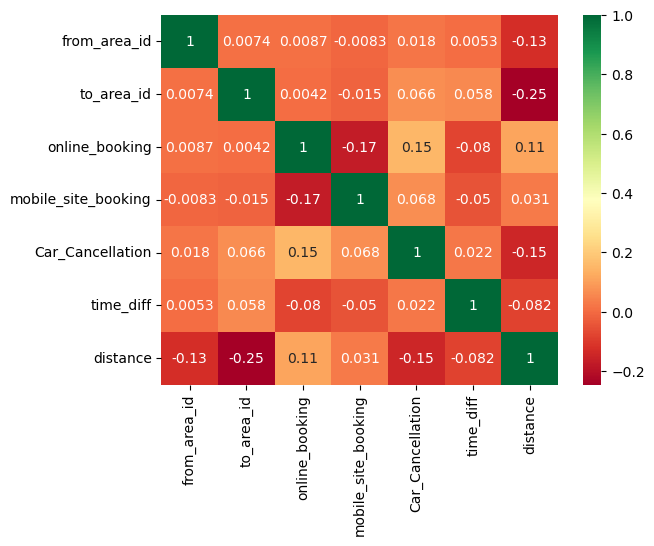

In [81]:
sns.heatmap(df2.corr(), annot = True, cmap = 'RdYlGn')

### Extracting features and target from df2

In [82]:
x2 = df2.drop(columns = 'Car_Cancellation')
x2.head()

,from_area_id,to_area_id,online_booking,mobile_site_booking,from_date_session,booking_created_session,time_diff,distance
0,83.0,448.0,0,0,Late Night,Late Night,21.0,3.980687
1,1010.0,540.0,0,0,Morning,Late Night,395.0,14.004432
2,1301.0,1034.0,0,0,Late Night,Late Night,22.0,12.648909
3,768.0,398.0,0,0,Early Morning,Late Night,66.0,9.534596
4,1365.0,849.0,0,0,Morning,Early Morning,67.0,14.655467


In [83]:
y2 = df2['Car_Cancellation']
y2.head()

0    0
1    0
2    0
3    0
4    0
Name: Car_Cancellation, dtype: int64

In [84]:
y2.value_counts()

0    31517
1     2775
Name: Car_Cancellation, dtype: int64

### Splitting the data

In [86]:
xtrain2, xtest2, ytrain2, ytest2 = train_test_split(x2,y2,train_size=0.85,random_state=30,stratify=y2)

In [87]:
xtrain2

,from_area_id,to_area_id,online_booking,mobile_site_booking,from_date_session,booking_created_session,time_diff,distance
33932,393.0,603.0,1,0,Afternoon,Afternoon,70.0,27.101348
39241,934.0,580.0,1,0,Afternoon,Morning,232.0,5.586024
34494,585.0,292.0,0,0,Late Night,Evening,575.0,7.394413
11001,271.0,393.0,0,0,Night,Afternoon,629.0,27.839323
41878,1084.0,1365.0,1,0,Early Morning,Early Morning,125.0,11.651155
...,...,...,...,...,...,...,...,...
39823,393.0,1312.0,1,0,Early Morning,Morning,1309.0,40.141386
19293,1133.0,585.0,1,0,Late Night,Night,409.0,12.927710
5192,296.0,463.0,0,0,Evening,Evening,154.0,2.006471
17549,1330.0,1384.0,0,0,Afternoon,Morning,118.0,19.269351


In [88]:
xtest2

,from_area_id,to_area_id,online_booking,mobile_site_booking,from_date_session,booking_created_session,time_diff,distance
28557,450.0,393.0,0,1,Afternoon,Night,928.0,30.708322
2485,420.0,243.0,1,0,Afternoon,Afternoon,198.0,39.550558
41952,1304.0,97.0,0,0,Early Morning,Evening,728.0,5.736785
29803,603.0,393.0,0,0,Morning,Morning,164.0,27.101348
42048,393.0,1096.0,0,1,Evening,Afternoon,355.0,25.963706
...,...,...,...,...,...,...,...,...
34720,137.0,393.0,0,0,Afternoon,Afternoon,90.0,42.529539
16763,912.0,572.0,0,0,Evening,Morning,475.0,0.909450
37255,393.0,1074.0,1,0,Late Night,Evening,460.0,27.356404
27580,269.0,97.0,1,0,Morning,Evening,774.0,3.364113


### Data Scaling

In [91]:
xtrain2['time_diff'] = m2s.fit_transform(xtrain2[['time_diff']])
xtrain2.head()

,from_area_id,to_area_id,online_booking,mobile_site_booking,from_date_session,booking_created_session,time_diff,distance
33932,393.0,603.0,1,0,Afternoon,Afternoon,0.012471,27.101348
39241,934.0,580.0,1,0,Afternoon,Morning,0.013870,5.586024
34494,585.0,292.0,0,0,Late Night,Evening,0.016832,7.394413
11001,271.0,393.0,0,0,Night,Afternoon,0.017299,27.839323
41878,1084.0,1365.0,1,0,Early Morning,Early Morning,0.012946,11.651155


In [92]:
xtest2['time_diff'] = m2s.transform(xtest2[['time_diff']])
xtest2.head()

,from_area_id,to_area_id,online_booking,mobile_site_booking,from_date_session,booking_created_session,time_diff,distance
28557,450.0,393.0,0,1,Afternoon,Night,0.019881,30.708322
2485,420.0,243.0,1,0,Afternoon,Afternoon,0.013577,39.550558
41952,1304.0,97.0,0,0,Early Morning,Evening,0.018154,5.736785
29803,603.0,393.0,0,0,Morning,Morning,0.013283,27.101348
42048,393.0,1096.0,0,1,Evening,Afternoon,0.014932,25.963706


### Data Encoding

In [93]:
# One-hot encoding for the columns from_date_session and booking_created_session

from_date_dummy_2 = pd.get_dummies(xtrain2['from_date_session'], drop_first=True)

In [94]:
from_date_dummy_2

,Early Morning,Evening,Late Night,Morning,Night
33932,0,0,0,0,0
39241,0,0,0,0,0
34494,0,0,1,0,0
11001,0,0,0,0,1
41878,1,0,0,0,0
...,...,...,...,...,...
39823,1,0,0,0,0
19293,0,0,1,0,0
5192,0,1,0,0,0
17549,0,0,0,0,0


In [95]:
xtrain2['Early_Morning'] = from_date_dummy_2['Early Morning']
xtrain2['Evening'] = from_date_dummy_2['Evening']
xtrain2['Late_Night'] = from_date_dummy_2['Late Night']
xtrain2['Morning'] = from_date_dummy_2['Morning']
xtrain2['Night'] = from_date_dummy_2['Night']
del xtrain2['from_date_session']

In [96]:
booking_created_dummy_2 = pd.get_dummies(xtrain2['booking_created_session'], drop_first=True)

In [97]:
booking_created_dummy_2

,Early Morning,Evening,Late Night,Morning,Night
33932,0,0,0,0,0
39241,0,0,0,1,0
34494,0,1,0,0,0
11001,0,0,0,0,0
41878,1,0,0,0,0
...,...,...,...,...,...
39823,0,0,0,1,0
19293,0,0,0,0,1
5192,0,1,0,0,0
17549,0,0,0,1,0


In [98]:
xtrain2['Early_Morning_booking'] = booking_created_dummy_2['Early Morning']
xtrain2['Evening_booking'] = booking_created_dummy_2['Evening']
xtrain2['Late_Night_booking'] = booking_created_dummy_2['Late Night']
xtrain2['Morning_booking'] = booking_created_dummy_2['Morning']
xtrain2['Night_booking'] = booking_created_dummy_2['Night']
del xtrain2['booking_created_session']

In [99]:
xtrain2

,from_area_id,to_area_id,online_booking,mobile_site_booking,time_diff,distance,Early_Morning,Evening,Late_Night,Morning,Night,Early_Morning_booking,Evening_booking,Late_Night_booking,Morning_booking,Night_booking
33932,393.0,603.0,1,0,0.012471,27.101348,0,0,0,0,0,0,0,0,0,0
39241,934.0,580.0,1,0,0.013870,5.586024,0,0,0,0,0,0,0,0,1,0
34494,585.0,292.0,0,0,0.016832,7.394413,0,0,1,0,0,0,1,0,0,0
11001,271.0,393.0,0,0,0.017299,27.839323,0,0,0,0,1,0,0,0,0,0
41878,1084.0,1365.0,1,0,0.012946,11.651155,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39823,393.0,1312.0,1,0,0.023172,40.141386,1,0,0,0,0,0,0,0,1,0
19293,1133.0,585.0,1,0,0.015399,12.927710,0,0,1,0,0,0,0,0,0,1
5192,296.0,463.0,0,0,0.013197,2.006471,0,1,0,0,0,0,1,0,0,0
17549,1330.0,1384.0,0,0,0.012886,19.269351,0,0,0,0,0,0,0,0,1,0


In [100]:
from_date_dummy_test_2 = pd.get_dummies(xtest2['from_date_session'], drop_first=True)

In [101]:
from_date_dummy_test_2

,Early Morning,Evening,Late Night,Morning,Night
28557,0,0,0,0,0
2485,0,0,0,0,0
41952,1,0,0,0,0
29803,0,0,0,1,0
42048,0,1,0,0,0
...,...,...,...,...,...
34720,0,0,0,0,0
16763,0,1,0,0,0
37255,0,0,1,0,0
27580,0,0,0,1,0


In [102]:
xtest2['Early_Morning'] = from_date_dummy_test_2['Early Morning']
xtest2['Evening'] = from_date_dummy_test_2['Evening']
xtest2['Late_Night'] = from_date_dummy_test_2['Late Night']
xtest2['Morning'] = from_date_dummy_test_2['Morning']
xtest2['Night'] = from_date_dummy_test_2['Night']
del xtest2['from_date_session']

In [103]:
booking_created_dummy_test_2 = pd.get_dummies(xtest2['booking_created_session'], drop_first=True)

In [104]:
booking_created_dummy_test_2

,Early Morning,Evening,Late Night,Morning,Night
28557,0,0,0,0,1
2485,0,0,0,0,0
41952,0,1,0,0,0
29803,0,0,0,1,0
42048,0,0,0,0,0
...,...,...,...,...,...
34720,0,0,0,0,0
16763,0,0,0,1,0
37255,0,1,0,0,0
27580,0,1,0,0,0


In [105]:
xtest2['Early_Morning_booking'] = booking_created_dummy_test_2['Early Morning']
xtest2['Evening_booking'] = booking_created_dummy_test_2['Evening']
xtest2['Late_Night_booking'] = booking_created_dummy_test_2['Late Night']
xtest2['Morning_booking'] = booking_created_dummy_test_2['Morning']
xtest2['Night_booking'] = booking_created_dummy_test_2['Night']
del xtest2['booking_created_session']

In [106]:
xtest2

,from_area_id,to_area_id,online_booking,mobile_site_booking,time_diff,distance,Early_Morning,Evening,Late_Night,Morning,Night,Early_Morning_booking,Evening_booking,Late_Night_booking,Morning_booking,Night_booking
28557,450.0,393.0,0,1,0.019881,30.708322,0,0,0,0,0,0,0,0,0,1
2485,420.0,243.0,1,0,0.013577,39.550558,0,0,0,0,0,0,0,0,0,0
41952,1304.0,97.0,0,0,0.018154,5.736785,1,0,0,0,0,0,1,0,0,0
29803,603.0,393.0,0,0,0.013283,27.101348,0,0,0,1,0,0,0,0,1,0
42048,393.0,1096.0,0,1,0.014932,25.963706,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34720,137.0,393.0,0,0,0.012644,42.529539,0,0,0,0,0,0,0,0,0,0
16763,912.0,572.0,0,0,0.015969,0.909450,0,1,0,0,0,0,0,0,1,0
37255,393.0,1074.0,1,0,0.015839,27.356404,0,0,1,0,0,0,1,0,0,0
27580,269.0,97.0,1,0,0.018551,3.364113,0,0,0,1,0,0,1,0,0,0


### Building the model for df2

In [107]:
# Logistic Regression

log_reg_2 = LogisticRegression(random_state=0)
log_reg_2.fit(xtrain2, ytrain2)

LogisticRegression(random_state=0)

In [108]:
# Decision Tree

dtc_2 = DecisionTreeClassifier(criterion='gini',random_state=4)

In [109]:
param_dist = {'max_depth': [3, 5, 6, 7], 'min_samples_split': [50, 100, 150, 200, 250]}
gscv_dtc_2 = GridSearchCV(dtc_2, cv=10, param_grid=param_dist, n_jobs=-1)
gscv_dtc_2.fit(xtrain2, ytrain2)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=4), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 7],
                         'min_samples_split': [50, 100, 150, 200, 250]})

In [110]:
gscv_dtc_2.best_params_

{'max_depth': 7, 'min_samples_split': 250}

In [111]:
dtc_2 = DecisionTreeClassifier(criterion='gini', random_state = 4, max_depth = 7, min_samples_split = 250)
dtc_2.fit(xtrain2, ytrain2)

DecisionTreeClassifier(max_depth=7, min_samples_split=250, random_state=4)

### Prediction for test dataset

In [112]:
ypred_lr_2 =log_reg_2.predict(xtest2)
ypred_lr_2

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [113]:
ypred_dtc_2 = dtc_2.predict(xtest2)
ypred_dtc_2

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### Model evaluation

In [114]:
conf_matrix = confusion_matrix(ytest2, ypred_lr_2)
conf_matrix

array([[4728,    0],
       [ 416,    0]], dtype=int64)

<Axes: >

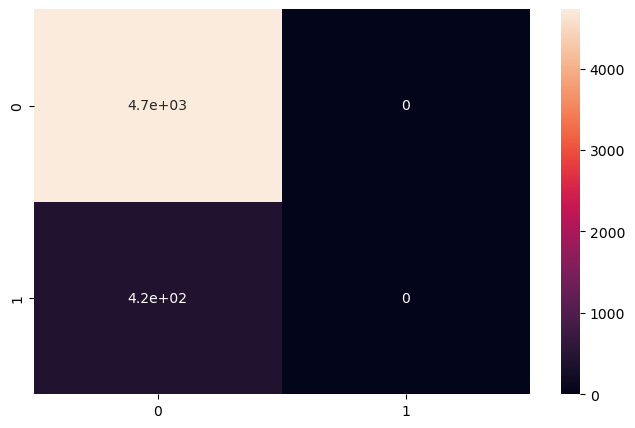

In [115]:
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(conf_matrix, annot = True, ax=ax)

In [116]:
print("Report for Logistic Regression")
print("______________________________")
print("\n")
print(classification_report(ytest2, ypred_lr_2))

Report for Logistic Regression
______________________________


              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4728
           1       0.00      0.00      0.00       416

    accuracy                           0.92      5144
   macro avg       0.46      0.50      0.48      5144
weighted avg       0.84      0.92      0.88      5144



In [117]:
conf_matrix = confusion_matrix(ytest2, ypred_dtc_2)
conf_matrix

array([[4710,   18],
       [ 407,    9]], dtype=int64)

<Axes: >

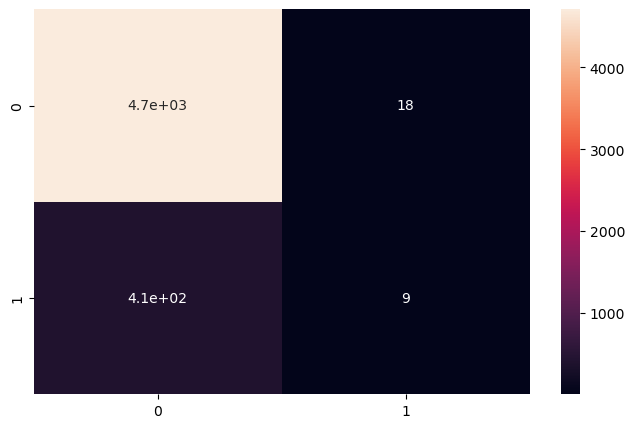

In [122]:
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(conf_matrix, annot = True, ax=ax)

In [118]:
print("Report for Decision Tree Model")
print("______________________________")
print("\n")
print(classification_report(ytest2, ypred_dtc_2))

Report for Decision Tree Model
______________________________


              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4728
           1       0.33      0.02      0.04       416

    accuracy                           0.92      5144
   macro avg       0.63      0.51      0.50      5144
weighted avg       0.87      0.92      0.88      5144



### ROC and AUC

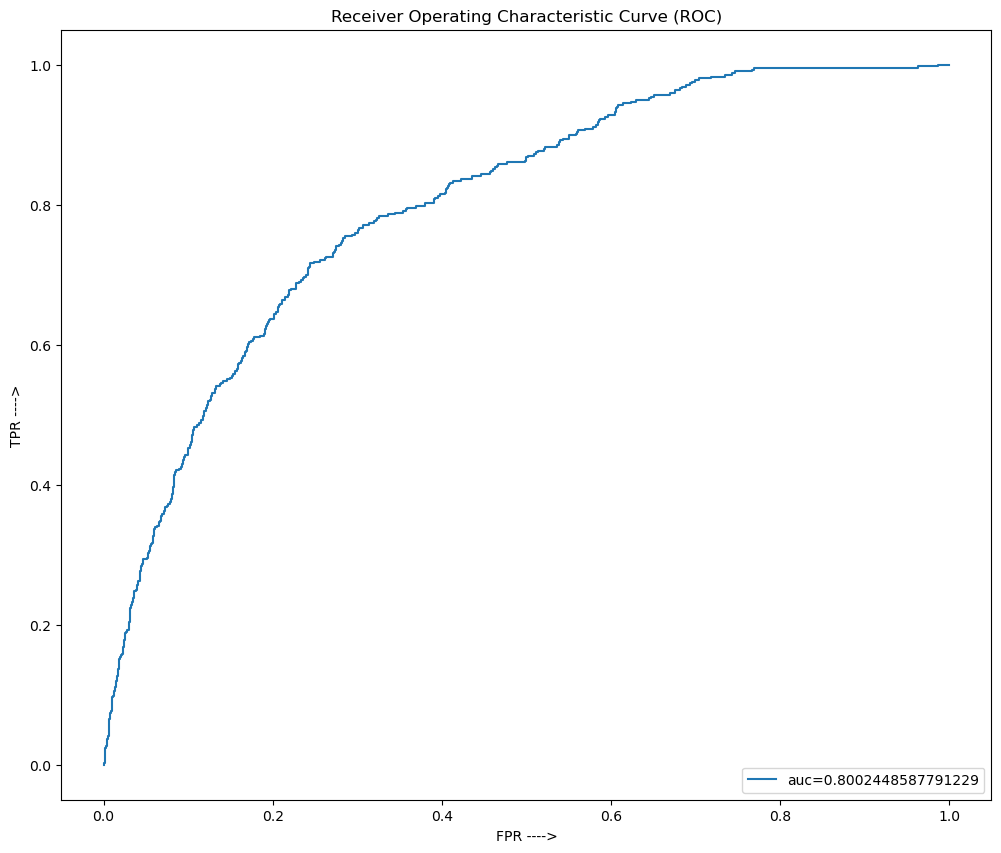

In [120]:
y_pred_proba_2 = log_reg_2.predict_proba(xtest2)[::,1]
fpr, tpr, _ = metrics.roc_curve(ytest2,  y_pred_proba_2)
auc = metrics.roc_auc_score(ytest2, y_pred_proba_2)
plt.figure(figsize=(12,10))
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.title("Receiver Operating Characteristic Curve (ROC)")
plt.xlabel("FPR ---->")
plt.ylabel("TPR ---->")
plt.show()

#### Here AUC is 0.8 which means this model predicts higher TP than FP which implies it is a good model

# Working with the 3rd dataset - df3

In [123]:
df3

,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation
8,2.0,3,448.0,NaN,NaN,NaN,01-01-2013 16:00,0,0,01-01-2013 09:44,12.927320,77.635750,NaN,NaN,0
20,2.0,3,471.0,NaN,NaN,NaN,01-01-2013 14:30,0,0,01-01-2013 12:52,13.018540,77.635240,NaN,NaN,0
23,1.0,3,1286.0,NaN,NaN,NaN,01-01-2013 16:30,0,0,01-01-2013 14:39,12.973448,77.620320,NaN,NaN,0
34,1.0,3,1323.0,NaN,NaN,NaN,01-01-2013 20:00,1,0,01-01-2013 17:25,12.869805,77.653211,NaN,NaN,0
47,2.0,3,142.0,NaN,NaN,NaN,01-02-2013 03:00,0,0,01-01-2013 19:37,12.912810,77.609230,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43415,1.0,3,768.0,NaN,15.0,NaN,11/24/2013 16:00,0,1,11/24/2013 12:32,12.989990,77.553320,NaN,NaN,0
43417,4.0,3,1390.0,NaN,15.0,NaN,11/24/2013 15:00,0,0,11/24/2013 13:06,12.969368,77.641302,NaN,NaN,0
43420,2.0,3,1237.0,NaN,15.0,NaN,11/25/2013 1:00,1,0,11/24/2013 13:54,12.926450,77.612060,NaN,NaN,0
43424,2.0,3,515.0,NaN,15.0,NaN,11/24/2013 15:15,0,0,11/24/2013 14:23,12.978960,77.673450,NaN,NaN,0


In [124]:
df3.isnull().sum()

package_id                0
travel_type_id            0
from_area_id              0
to_area_id             7550
from_city_id           7102
to_city_id             7550
from_date                 0
online_booking            0
mobile_site_booking       0
booking_created           0
from_lat                  0
from_long                 0
to_lat                 7550
to_long                7550
Car_Cancellation          0
dtype: int64

In [125]:
# Deleting columns having all or max null values

df3.drop(columns = ['travel_type_id', 'to_area_id', 'from_city_id', 'to_city_id', 'to_lat', 'to_long'], inplace = True)

In [126]:
# Analysing the correlation between from_area_id with from_lat and from_long
# Taking any one value of from_area_id for eg

df3.loc[df3['from_area_id'] == 448.0]

,package_id,from_area_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,Car_Cancellation
8,2.0,448.0,01-01-2013 16:00,0,0,01-01-2013 09:44,12.92732,77.63575,0
811,2.0,448.0,01-11-2013 12:30,0,0,01-11-2013 09:43,12.92732,77.63575,0
3228,1.0,448.0,02-03-2013 16:00,0,0,02-03-2013 14:55,12.92732,77.63575,0
6745,1.0,448.0,03-11-2013 11:30,0,0,03-11-2013 10:37,12.92732,77.63575,0
7771,1.0,448.0,3/24/2013 10:30,0,0,3/24/2013 10:03,12.92732,77.63575,0
8214,2.0,448.0,3/29/2013 10:00,1,0,3/28/2013 18:04,12.92732,77.63575,0
8524,1.0,448.0,3/31/2013 12:45,1,0,3/31/2013 11:17,12.92732,77.63575,1
9092,1.0,448.0,04-06-2013 18:45,1,0,04-06-2013 09:44,12.92732,77.63575,0
9145,2.0,448.0,04-07-2013 06:45,0,0,04-06-2013 20:23,12.92732,77.63575,0
9259,2.0,448.0,04-09-2013 06:45,0,0,04-08-2013 07:43,12.92732,77.63575,0


In [127]:
# From the above eg, for the same value of 448 for from_area_id, we are getting the same values for from_lat and from_long so the latter 2 columns are redundent so dropping them

df3.drop(columns = ['from_lat', 'from_long'], inplace = True)
df3

,package_id,from_area_id,from_date,online_booking,mobile_site_booking,booking_created,Car_Cancellation
8,2.0,448.0,01-01-2013 16:00,0,0,01-01-2013 09:44,0
20,2.0,471.0,01-01-2013 14:30,0,0,01-01-2013 12:52,0
23,1.0,1286.0,01-01-2013 16:30,0,0,01-01-2013 14:39,0
34,1.0,1323.0,01-01-2013 20:00,1,0,01-01-2013 17:25,0
47,2.0,142.0,01-02-2013 03:00,0,0,01-01-2013 19:37,0
...,...,...,...,...,...,...,...
43415,1.0,768.0,11/24/2013 16:00,0,1,11/24/2013 12:32,0
43417,4.0,1390.0,11/24/2013 15:00,0,0,11/24/2013 13:06,0
43420,2.0,1237.0,11/25/2013 1:00,1,0,11/24/2013 13:54,0
43424,2.0,515.0,11/24/2013 15:15,0,0,11/24/2013 14:23,0


In [128]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7550 entries, 8 to 43428
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   package_id           7550 non-null   float64
 1   from_area_id         7550 non-null   float64
 2   from_date            7550 non-null   object 
 3   online_booking       7550 non-null   int64  
 4   mobile_site_booking  7550 non-null   int64  
 5   booking_created      7550 non-null   object 
 6   Car_Cancellation     7550 non-null   int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 471.9+ KB


### Extracting date and time from timestamp

In [129]:
df3['from_time_tm'] = pd.to_datetime(df3['from_date']).dt.strftime('%H:%M') # extracting time component from from_date column
df3['booking_created_tm'] = pd.to_datetime(df3['booking_created']).dt.strftime('%H:%M') # extracting time component from booking_created column

# Classifying the time into different segments for both the columns

cond = [(pd.to_datetime(df3['from_time_tm']).dt.hour.between(5, 8)),
        (pd.to_datetime(df3['from_time_tm']).dt.hour.between(9, 12)),
        (pd.to_datetime(df3['from_time_tm']).dt.hour.between(13, 16)),
        (pd.to_datetime(df3['from_time_tm']).dt.hour.between(17, 20)),
        ((pd.to_datetime(df3['from_time_tm']).dt.hour.between(21, 24)) | (pd.to_datetime(df3['from_time_tm']).dt.hour==0)),
        (pd.to_datetime(df3['from_time_tm']).dt.hour.between(1, 4))]
values = ['Early Morning','Morning','Afternoon','Evening','Night','Late Night']
df3['from_date_session'] = np.select(cond,values)

cond = [(pd.to_datetime(df3['booking_created_tm']).dt.hour.between(5, 8)),
        (pd.to_datetime(df3['booking_created_tm']).dt.hour.between(9, 12)),
        (pd.to_datetime(df3['booking_created_tm']).dt.hour.between(13, 16)),
        (pd.to_datetime(df3['booking_created_tm']).dt.hour.between(17, 20)),
        ((pd.to_datetime(df3['booking_created_tm']).dt.hour.between(21, 24)) | (pd.to_datetime(df3['booking_created_tm']).dt.hour==0)),
        (pd.to_datetime(df3['booking_created_tm']).dt.hour.between(1, 4))]
values = ['Early Morning','Morning','Afternoon','Evening','Night','Late Night']
df3['booking_created_session'] = np.select(cond,values)

In [130]:
# creating a new column which calculates the time difference between booking time and scheduled travel time

df3['time_diff'] = (pd.to_datetime(df3['from_date']) - pd.to_datetime(df3['booking_created'])).astype('timedelta64[m]')

In [131]:
df3.drop(columns = ['from_date', 'booking_created', 'from_time_tm', 'booking_created_tm'], inplace = True)

In [132]:
df3

,package_id,from_area_id,online_booking,mobile_site_booking,Car_Cancellation,from_date_session,booking_created_session,time_diff
8,2.0,448.0,0,0,0,Afternoon,Morning,376.0
20,2.0,471.0,0,0,0,Afternoon,Morning,98.0
23,1.0,1286.0,0,0,0,Afternoon,Afternoon,111.0
34,1.0,1323.0,1,0,0,Evening,Evening,155.0
47,2.0,142.0,0,0,0,Late Night,Evening,443.0
...,...,...,...,...,...,...,...,...
43415,1.0,768.0,0,1,0,Afternoon,Morning,208.0
43417,4.0,1390.0,0,0,0,Afternoon,Afternoon,114.0
43420,2.0,1237.0,1,0,0,Late Night,Afternoon,666.0
43424,2.0,515.0,0,0,0,Afternoon,Afternoon,52.0


### Extracting features and target from df3

In [133]:
x3 = df3.drop(columns = 'Car_Cancellation')
x3.head()

,package_id,from_area_id,online_booking,mobile_site_booking,from_date_session,booking_created_session,time_diff
8,2.0,448.0,0,0,Afternoon,Morning,376.0
20,2.0,471.0,0,0,Afternoon,Morning,98.0
23,1.0,1286.0,0,0,Afternoon,Afternoon,111.0
34,1.0,1323.0,1,0,Evening,Evening,155.0
47,2.0,142.0,0,0,Late Night,Evening,443.0


In [134]:
y3 = df3['Car_Cancellation']
y3.head()

8     0
20    0
23    0
34    0
47    0
Name: Car_Cancellation, dtype: int64

In [135]:
y3.value_counts()

0    7214
1     336
Name: Car_Cancellation, dtype: int64

### Splitting the data

In [136]:
xtrain3, xtest3, ytrain3, ytest3 = train_test_split(x3,y3,train_size=0.85,random_state=30,stratify=y3)

In [137]:
xtrain3

,package_id,from_area_id,online_booking,mobile_site_booking,from_date_session,booking_created_session,time_diff
11683,2.0,112.0,0,0,Night,Morning,694.0
16321,2.0,1257.0,1,0,Early Morning,Evening,487.0
18906,1.0,58.0,1,0,Morning,Morning,122.0
19619,2.0,393.0,1,0,Morning,Morning,2681.0
38702,6.0,953.0,0,0,Early Morning,Afternoon,981.0
...,...,...,...,...,...,...,...
24945,2.0,1163.0,1,0,Late Night,Evening,416.0
42461,7.0,1096.0,0,0,Late Night,Evening,388.0
34083,1.0,1017.0,0,0,Evening,Afternoon,79.0
41715,4.0,1312.0,0,1,Late Night,Evening,467.0


In [138]:
xtest3

,package_id,from_area_id,online_booking,mobile_site_booking,from_date_session,booking_created_session,time_diff
5816,1.0,293.0,0,0,Morning,Early Morning,71.0
40235,4.0,376.0,0,1,Early Morning,Night,578.0
6043,2.0,357.0,0,0,Afternoon,Morning,94.0
27029,3.0,293.0,1,0,Afternoon,Afternoon,133.0
4158,1.0,1010.0,0,0,Early Morning,Early Morning,64.0
...,...,...,...,...,...,...,...
40033,6.0,1026.0,0,0,Afternoon,Evening,1045.0
14457,1.0,344.0,0,0,Evening,Evening,204.0
36509,1.0,689.0,1,0,Early Morning,Night,643.0
37143,6.0,1085.0,0,0,Early Morning,Night,548.0


### Data Scaling

In [139]:
xtrain3['time_diff'] = m2s.fit_transform(xtrain3[['time_diff']])
xtrain3.head()

,package_id,from_area_id,online_booking,mobile_site_booking,from_date_session,booking_created_session,time_diff
11683,2.0,112.0,0,0,Night,Morning,0.021623
16321,2.0,1257.0,1,0,Early Morning,Evening,0.016688
18906,1.0,58.0,1,0,Morning,Morning,0.007986
19619,2.0,393.0,1,0,Morning,Morning,0.068993
38702,6.0,953.0,0,0,Early Morning,Afternoon,0.028465


In [140]:
xtest3['time_diff'] = m2s.transform(xtest3[['time_diff']])
xtest3.head()

,package_id,from_area_id,online_booking,mobile_site_booking,from_date_session,booking_created_session,time_diff
5816,1.0,293.0,0,0,Morning,Early Morning,0.006771
40235,4.0,376.0,0,1,Early Morning,Night,0.018858
6043,2.0,357.0,0,0,Afternoon,Morning,0.007319
27029,3.0,293.0,1,0,Afternoon,Afternoon,0.008249
4158,1.0,1010.0,0,0,Early Morning,Early Morning,0.006604


### Data encoding

In [141]:
# One-hot encoding for the columns from_date_session and booking_created_session

from_date_dummy_3 = pd.get_dummies(xtrain3['from_date_session'], drop_first=True)

In [142]:
from_date_dummy_3

,Early Morning,Evening,Late Night,Morning,Night
11683,0,0,0,0,1
16321,1,0,0,0,0
18906,0,0,0,1,0
19619,0,0,0,1,0
38702,1,0,0,0,0
...,...,...,...,...,...
24945,0,0,1,0,0
42461,0,0,1,0,0
34083,0,1,0,0,0
41715,0,0,1,0,0


In [143]:
xtrain3['Early_Morning'] = from_date_dummy_3['Early Morning']
xtrain3['Evening'] = from_date_dummy_3['Evening']
xtrain3['Late_Night'] = from_date_dummy_3['Late Night']
xtrain3['Morning'] = from_date_dummy_3['Morning']
xtrain3['Night'] = from_date_dummy_3['Night']
del xtrain3['from_date_session']

In [144]:
booking_created_dummy_3 = pd.get_dummies(xtrain3['booking_created_session'], drop_first=True)

In [145]:
booking_created_dummy_3

,Early Morning,Evening,Late Night,Morning,Night
11683,0,0,0,1,0
16321,0,1,0,0,0
18906,0,0,0,1,0
19619,0,0,0,1,0
38702,0,0,0,0,0
...,...,...,...,...,...
24945,0,1,0,0,0
42461,0,1,0,0,0
34083,0,0,0,0,0
41715,0,1,0,0,0


In [146]:
xtrain3['Early_Morning_booking'] = booking_created_dummy_3['Early Morning']
xtrain3['Evening_booking'] = booking_created_dummy_3['Evening']
xtrain3['Late_Night_booking'] = booking_created_dummy_3['Late Night']
xtrain3['Morning_booking'] = booking_created_dummy_3['Morning']
xtrain3['Night_booking'] = booking_created_dummy_3['Night']
del xtrain3['booking_created_session']

In [147]:
xtrain3

,package_id,from_area_id,online_booking,mobile_site_booking,time_diff,Early_Morning,Evening,Late_Night,Morning,Night,Early_Morning_booking,Evening_booking,Late_Night_booking,Morning_booking,Night_booking
11683,2.0,112.0,0,0,0.021623,0,0,0,0,1,0,0,0,1,0
16321,2.0,1257.0,1,0,0.016688,1,0,0,0,0,0,1,0,0,0
18906,1.0,58.0,1,0,0.007986,0,0,0,1,0,0,0,0,1,0
19619,2.0,393.0,1,0,0.068993,0,0,0,1,0,0,0,0,1,0
38702,6.0,953.0,0,0,0.028465,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24945,2.0,1163.0,1,0,0.014995,0,0,1,0,0,0,1,0,0,0
42461,7.0,1096.0,0,0,0.014328,0,0,1,0,0,0,1,0,0,0
34083,1.0,1017.0,0,0,0.006961,0,1,0,0,0,0,0,0,0,0
41715,4.0,1312.0,0,1,0.016211,0,0,1,0,0,0,1,0,0,0


In [148]:
from_date_dummy_test_3 = pd.get_dummies(xtest3['from_date_session'], drop_first=True)

In [149]:
from_date_dummy_test_3

,Early Morning,Evening,Late Night,Morning,Night
5816,0,0,0,1,0
40235,1,0,0,0,0
6043,0,0,0,0,0
27029,0,0,0,0,0
4158,1,0,0,0,0
...,...,...,...,...,...
40033,0,0,0,0,0
14457,0,1,0,0,0
36509,1,0,0,0,0
37143,1,0,0,0,0


In [150]:
xtest3['Early_Morning'] = from_date_dummy_test_3['Early Morning']
xtest3['Evening'] = from_date_dummy_test_3['Evening']
xtest3['Late_Night'] = from_date_dummy_test_3['Late Night']
xtest3['Morning'] = from_date_dummy_test_3['Morning']
xtest3['Night'] = from_date_dummy_test_3['Night']
del xtest3['from_date_session']

In [151]:
booking_created_dummy_test_3 = pd.get_dummies(xtest3['booking_created_session'], drop_first=True)

In [152]:
booking_created_dummy_test_3

,Early Morning,Evening,Late Night,Morning,Night
5816,1,0,0,0,0
40235,0,0,0,0,1
6043,0,0,0,1,0
27029,0,0,0,0,0
4158,1,0,0,0,0
...,...,...,...,...,...
40033,0,1,0,0,0
14457,0,1,0,0,0
36509,0,0,0,0,1
37143,0,0,0,0,1


In [153]:
xtest3['Early_Morning_booking'] = booking_created_dummy_test_3['Early Morning']
xtest3['Evening_booking'] = booking_created_dummy_test_3['Evening']
xtest3['Late_Night_booking'] = booking_created_dummy_test_3['Late Night']
xtest3['Morning_booking'] = booking_created_dummy_test_3['Morning']
xtest3['Night_booking'] = booking_created_dummy_test_3['Night']
del xtest3['booking_created_session']

In [154]:
xtest3

,package_id,from_area_id,online_booking,mobile_site_booking,time_diff,Early_Morning,Evening,Late_Night,Morning,Night,Early_Morning_booking,Evening_booking,Late_Night_booking,Morning_booking,Night_booking
5816,1.0,293.0,0,0,0.006771,0,0,0,1,0,1,0,0,0,0
40235,4.0,376.0,0,1,0.018858,1,0,0,0,0,0,0,0,0,1
6043,2.0,357.0,0,0,0.007319,0,0,0,0,0,0,0,0,1,0
27029,3.0,293.0,1,0,0.008249,0,0,0,0,0,0,0,0,0,0
4158,1.0,1010.0,0,0,0.006604,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40033,6.0,1026.0,0,0,0.029991,0,0,0,0,0,0,1,0,0,0
14457,1.0,344.0,0,0,0.009941,0,1,0,0,0,0,1,0,0,0
36509,1.0,689.0,1,0,0.020407,1,0,0,0,0,0,0,0,0,1
37143,6.0,1085.0,0,0,0.018142,1,0,0,0,0,0,0,0,0,1


### Building the model for df3

In [155]:
# Logistic Regression

log_reg_3 = LogisticRegression(random_state=0)
log_reg_3.fit(xtrain3, ytrain3)

LogisticRegression(random_state=0)

In [156]:
# Decision Tree

dtc_3 = DecisionTreeClassifier(criterion='gini',random_state=4)

In [157]:
param_dist = {'max_depth': [3, 5, 6, 7], 'min_samples_split': [50, 100, 150, 200, 250]}
gscv_dtc_3 = GridSearchCV(dtc_3, cv=10, param_grid=param_dist, n_jobs=-1)
gscv_dtc_3.fit(xtrain3, ytrain3)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=4), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 7],
                         'min_samples_split': [50, 100, 150, 200, 250]})

In [158]:
gscv_dtc_3.best_params_

{'max_depth': 3, 'min_samples_split': 50}

In [159]:
dtc_3 = DecisionTreeClassifier(criterion='gini', random_state = 4, max_depth = 3, min_samples_split = 50)
dtc_3.fit(xtrain3, ytrain3)

DecisionTreeClassifier(max_depth=3, min_samples_split=50, random_state=4)

### Prediction for test dataset

In [160]:
ypred_lr_3 =log_reg_3.predict(xtest3)
ypred_lr_3

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [161]:
ypred_dtc_3 = dtc_3.predict(xtest3)
ypred_dtc_3

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### Model evaluation

In [162]:
conf_matrix = confusion_matrix(ytest3, ypred_lr_3)
conf_matrix

array([[1083,    0],
       [  50,    0]], dtype=int64)

<Axes: >

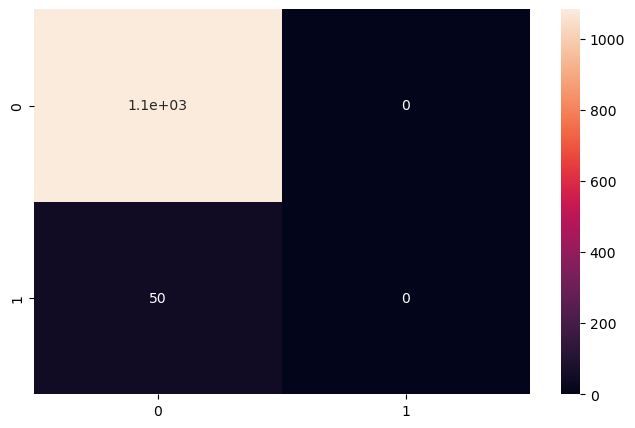

In [163]:
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(conf_matrix, annot = True, ax=ax)

In [164]:
print("Report for Logistic Regression")
print("______________________________")
print("\n")
print(classification_report(ytest3, ypred_lr_3))

Report for Logistic Regression
______________________________


              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1083
           1       0.00      0.00      0.00        50

    accuracy                           0.96      1133
   macro avg       0.48      0.50      0.49      1133
weighted avg       0.91      0.96      0.93      1133



In [165]:
conf_matrix = confusion_matrix(ytest3, ypred_dtc_3)
conf_matrix

array([[1083,    0],
       [  50,    0]], dtype=int64)

<Axes: >

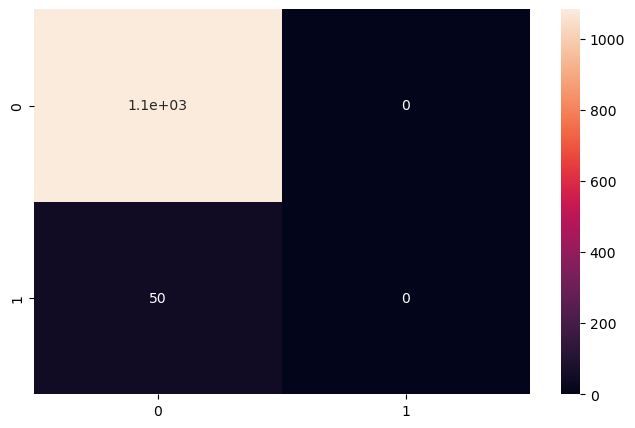

In [166]:
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(conf_matrix, annot = True, ax=ax)

In [167]:
print("Report for Decision Tree Model")
print("______________________________")
print("\n")
print(classification_report(ytest3, ypred_dtc_3))

Report for Decision Tree Model
______________________________


              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1083
           1       0.00      0.00      0.00        50

    accuracy                           0.96      1133
   macro avg       0.48      0.50      0.49      1133
weighted avg       0.91      0.96      0.93      1133



### ROC and AUC

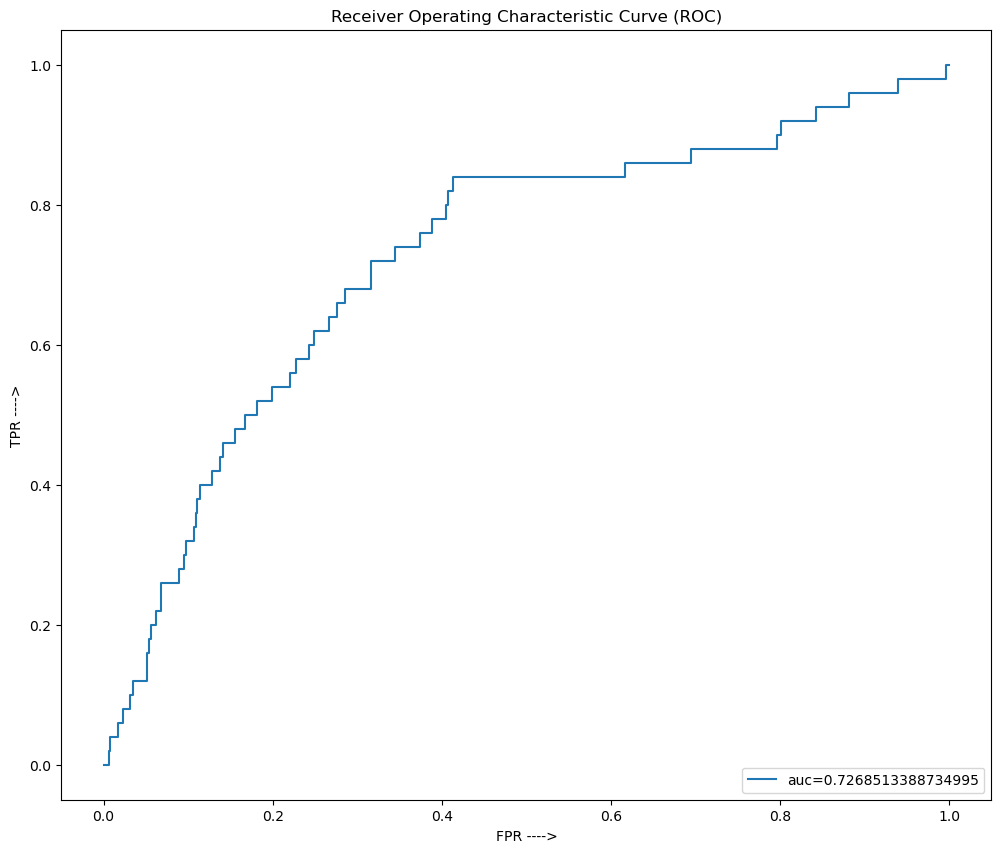

In [168]:
y_pred_proba_3 = log_reg_3.predict_proba(xtest3)[::,1]
fpr, tpr, _ = metrics.roc_curve(ytest3,  y_pred_proba_3)
auc = metrics.roc_auc_score(ytest3, y_pred_proba_3)
plt.figure(figsize=(12,10))
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.title("Receiver Operating Characteristic Curve (ROC)")
plt.xlabel("FPR ---->")
plt.ylabel("TPR ---->")
plt.show()

#### Here AUC is 0.72 which means this model predicts higher TP than FP which implies it is a good model